dataset:

---

https://github.com/liaopeiyuan/artbench

# Experiments tried in this notebook:

0Nr. ) Experiment Name

Idea:

Result:

Conclusion:

# Import of libraries, creation of the experiment

In [ ]:
# mlflow dependencies
!pip install mlflow pyngrok --quiet

In [ ]:
from google.colab import drive
# add flag force_remount=True if you changed or added util files
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# common utils for training functions
# change the path to google drive if elsewhere.
# this copies all of the utils file from drive to separate folder
# if this does not work you can always add functions manualy

import sys
if '/content/utils' not in sys.path:
  sys.path.insert(0, '/content/utils')

!cp -r '/content/drive/My Drive/Colab Notebooks/utils' '/content'

In [ ]:
# load mlflow.db from the google drive, so experiments will be present, but without any artifacts
!cp  /content/drive/My\ Drive/Colab\ Notebooks/mlflow_data/mlruns.db  /content/mlruns.db

In [ ]:
!ls '/content'

drive  mlruns.db  sample_data  utils


In [ ]:
from artworks_helpers import *
from fastai_utils import *
from mlflow_utils import *

In [ ]:
LOCAL_REGISTRY = "sqlite:///mlruns.db"
EXPERIMENT_NAME = "Artworks Classification"
MLFLOW_PORT = 5000

In [ ]:
mlfclient = create_mlflow_client(LOCAL_REGISTRY)

In [ ]:
experiment_tags = {
    "dataset": "artbench",
    "link": "https://github.com/liaopeiyuan/artbench",
}

In [ ]:
active_experiment_id = get_mlflow_experiment(mlfclient, EXPERIMENT_NAME, experiment_tags=experiment_tags)

In [ ]:
active_experiment_id

'1'

In [ ]:
# load only certain experiment from mlflow when needed, but create folders before
!mkdir -p /content/mlruns
!mkdir -p /content/mlruns/{active_experiment_id}


In [ ]:
print('current number of completed runs in experiment')
print(len(mlfclient.search_runs(experiment_ids=[active_experiment_id])))

# Preparation of reduced dataset, where paintings by artists in multiple genres are removed

In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data('https://artbench.eecs.berkeley.edu/files/artbench-10-imagefolder-split.tar')

# Preparation of dataloaders, model initalization with learning rate finder

In [ ]:
SPLIT_SEED = 42
VALID_PERCENTAGE = 0.2
BATCH_SIZE = 64

In [ ]:
RESNET18_PRETRAINED = 'resnet18_pretrained'
RESNET34_PRETRAINED = 'resnet34_pretrained'

In [ ]:
params_training_all_runs = {'data_split': 'random',
    'split_seed': SPLIT_SEED,
    'split_valid_pct': VALID_PERCENTAGE,
    'batch_tfms': 'Normalize.from_stats(*imagenet_stats)',
    'batch_size': BATCH_SIZE,
}


paintings = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items=get_image_files,
                splitter=RandomSplitter(seed=SPLIT_SEED, valid_pct=VALID_PERCENTAGE),
                batch_tfms=[Normalize.from_stats(*imagenet_stats)],
                get_y=parent_label)

dls = paintings.dataloaders(path/"train", bs=BATCH_SIZE)

In [ ]:
dls.show_batch()

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
params_training_all_runs['model_name'] = RESNET18_PRETRAINED

{'data_split': 'random', 'split_seed': 42, 'split_valid_pct': 0.2, 'batch_tfms': 'Normalize.from_stats(*imagenet_stats)', 'batch_size': 64, 'dataset_variation': 'reduced_artist_with_one_genre', 'model_name': 'resnet18_pretrained'}

metric: steep,  learning_rate:  0.001202
learning rate when the slope is the steepest, 
loss is decreasing most rapidly

metric: valley,  learning_rate:  0.001738
learning rate from the longest valley, 
this could be before the loss starts to increase rapidly

metric: slide,  learning_rate:  0.002512
learning rate following an interval slide rule, 
this could be when loss is decreasing just before the loss starts to increase rapidly

metric: minimum,  learning_rate:  0.010000
1/10th of the minimum point for the loss function, 
largest sensible value to use for learning rate, since minimum is to high



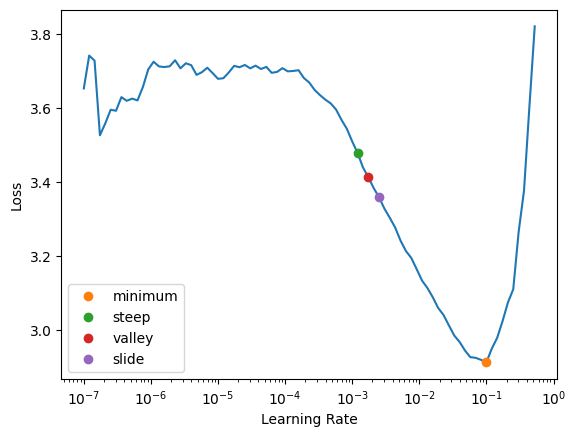

In [ ]:
learn_rate = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print(params_training_all_runs)
print()
format_lrs(learn_rate)

# Experiment

**0Nr. ) Experiment Name**

In [ ]:
with mlflow.start_run(experiment_id=active_experiment_id, run_name='experiment_name') as run:

    log_mlflow_params(mlfclient, run, params_training_all_runs)

    run_params = {"learning_rate": 0.005, 'num_epochs': 30, 'pct_start': 0.4, 'div':25, 'div_final':1e5}
    log_mlflow_params(mlfclient, run, run_params)

    cb_mlflow = MLFlowTracking(metric_names=['valid_loss', 'train_loss', 'error_rate'], client=mlfclient, run_id=run.info.run_id)

    learn.freeze()
    learn.fit_one_cycle(run_params['num_epochs'], lr_max=slice(run_params['learning_rate']), pct_start=run_params['pct_start'], div=run_params['div'], div_final=run_params['div_final'],
               cbs=[cb_mlflow, EarlyStoppingCallback(min_delta=0.001, patience=5)])

    save_fastai_model_as_artifact(mlfclient, run.info.run_id, learn, 'fastai_resnet18_train_only_frozen.pkl')

**Saving of the model data**

In [ ]:
run = get_last_run_id(mlfclient, active_experiment_id)

In [ ]:
import pickle

def store_fastai_train_recordings(learn, run, vocabulary = None ):
  # save loss recording plot
  loss_plot_path = "loss_plot.png"
  learn.recorder.plot_loss(show_epochs=True).figure.savefig(loss_plot_path)
  mlfclient.log_artifact(run.info.run_id, local_path=loss_plot_path,
          artifact_path='figures')

  interp = ClassificationInterpretation.from_learner(learn)

  # save interpretation object
  interp_path = "interpretation.pkl"
  with open(interp_path, "wb") as f:
      pickle.dump(interp, f)
  # Log the interpretation object as an artifact to the current MLflow run
  mlfclient.log_artifact(run.info.run_id, local_path=interp_path,
          artifact_path='interpetation' )

  # save confussion matrix image
  if vocabulary is not None:
    # this needs to be performed after saving pickel object,
    # so that you can serialize it.
    add_methods_to_interpetation(interp)
    interp.plot_confusion_matrix_vocab(vocabulary, figsize=(12,12), dpi=60).figure.savefig('confussion_matrix')
  else:
    interp.plot_confusion_matrix(figsize=(12,12), dpi=60).figure.savefig('confussion_matrix')

  mlfclient.log_artifact(run.info.run_id, local_path='confussion_matrix.png',
          artifact_path='figures' )

  # save learning rate and momentum comparison
  learn.recorder.plot_sched()
  plot_sched_figure = plt.gcf()
  image_plot_sched = 'scheduled_lr_mom.png'
  # you can retrieve the last image with this, since plot is bot returned
  # Now you can work with the last_figure object, e.g., save it
  plot_sched_figure.savefig(image_plot_sched)

  mlfclient.log_artifact(run.info.run_id, local_path=image_plot_sched,
          artifact_path='figures' )

In [ ]:
store_fastai_train_recordings(learn, run, genres_sorted_era)

**Copy back to server**

In [ ]:
# copy mlflow mlruns.db back to server
!cp   /content/mlruns.db  /content/drive/My\ Drive/Colab\ Notebooks/mlflow_data/mlruns.db

# copy mlflow_data back to server
!cp -r /content/mlruns    /content/drive/My\ Drive/Colab\ Notebooks/mlflow_data

# Interpretation of the results

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.print_classification_report()

In [ ]:
def distance(list_of_elems, el1, el2):
  return abs(list_of_elems.index(el1) - list_of_elems.index(el2))


In [ ]:
distance_formula = partial(distance, genres_sorted_era)
confused_counts = interp.most_confused()

In [ ]:
for count in confused_counts:
    print((count[0], count[1],  distance_formula(count[0], count[1]), count[2]))

# Mlfow how to start server to view results in colab


In [ ]:
start_mlflow_server_in_collab(LOCAL_REGISTRY, MLFLOW_PORT)

In [ ]:
!ps x | grep '[m]lflow ui'

In [ ]:
 ngrok_access_to_mlflow_in_collab(MLFLOW_PORT)